<img src="https://upload.wikimedia.org/wikipedia/commons/f/f3/Planet_Labs_logo.svg" alt="Drawing" style="width: 200px;"/>


## SentinelHub APIs
### Third Party Data Import 

The [SentinelHub TPDI API](https://docs.sentinel-hub.com/api/latest/api/data-import/) API enables you to import data offered by different data providers into Sentinel Hub (SH). The API allows you to:

- Search for available data
- Order the import of selected data into Sentinel Hub
- Subscribe to all data matching your criteria (for PlanetScope)

This notebook shows an example on how to use the TPDI API to search order and access PlanetScope imagery. 

---

## Table of Contents

1. **Authenticate**
2. **PlanetScope**
    - Search
    - Thumbnail
    - Order products
    - Order search
    - Confirm


Firstly, let's import the required libraries:

In [80]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
from sentinelhub import SHConfig

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from io import BytesIO
from PIL import Image
import numpy as np
import geopandas as gpd
import json
import io
import os
import getpass

In [81]:
config = SHConfig("SH_creds")
id = config.sh_client_id
secret = config.sh_client_secret
config

SHConfig(
  instance_id='',
  sh_client_id='********************************59a8',
  sh_client_secret='****************************N4HD',
  sh_base_url='https://services.sentinel-hub.com',
  sh_auth_base_url=None,
  sh_token_url='https://services.sentinel-hub.com/oauth/token',
  geopedia_wms_url='https://service.geopedia.world',
  geopedia_rest_url='https://www.geopedia.world/rest',
  aws_access_key_id='',
  aws_secret_access_key='',
  aws_session_token='',
  aws_metadata_url='https://roda.sentinel-hub.com',
  aws_s3_l1c_bucket='sentinel-s2-l1c',
  aws_s3_l2a_bucket='sentinel-s2-l2a',
  opensearch_url='http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2',
  max_wfs_records_per_query=100,
  max_opensearch_records_per_query=500,
  max_download_attempts=4,
  download_sleep_time=5.0,
  download_timeout_seconds=120.0,
  number_of_download_processes=1,
)

In [82]:
# Create a session
client = BackendApplicationClient(client_id=id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url="https://services.sentinel-hub.com/oauth/token", client_secret=secret)

### Check Quota

In [ ]:
# Set URL
url = "https://services.sentinel-hub.com/api/v1/dataimport/quotas"

# Send request
response = oauth.get(url=url)
response.raise_for_status()
response.json()

## 2. Planet Scope
### Search


<div class="alert alert-block alert-success">
<strong>NOTE</strong>: SentinelHub has two types of search: <a href="https://docs.sentinel-hub.com/api/latest/api/data-import/examples_planetscope/#simple-search">Simple</a> and <a href="https://docs.sentinel-hub.com/api/latest/api/data-import/examples_planetscope/#native-search">Native</a>. Both are almost identical, with the excemption that in the Native search Planet-native filters can be used. In this Notebook, the Simple search is implemented.
</div>



Before running the search, let's define the product bundle and AOI.

The query is built of three elements:
- **provider** -> PLANET
- **bounds** -> AOI geometry
- **data** -> search parameters

In [83]:
# BUNDLE
bundle = "analytic_sr_udm2"

# GEOMETRY
gdf = gpd.read_file("aoi/new_york_aoi.geojson")
geom = json.loads(gdf.to_json())["features"][0]["geometry"]
gdf.explore()

In [84]:
request = {
    "provider": "PLANET",
    "bounds": {"geometry": geom},
    "data": [
        {
            "itemType": "PSScene",
            "productBundle": bundle,
            "dataFilter": {
                "timeRange": {
                    "from": "2023-06-01T00:00:00.000Z",
                    "to": "2023-06-14T00:00:00.000Z",
                },
                # Add search parameters based on int metadata
                "maxCloudCoverage": 30,
                "heavy_haze_percent": 0,
                # Add search parameters baased on string metadata (StringInFilter)
                "nativeFilter": {
                    "type": "StringInFilter",
                    "field_name": "quality_category",
                    "config": ["standard"],
                    # Add another search filter
                    "type": "StringInFilter",
                    "field_name": "instrument",
                    "config": ["PSB.SD"],
                },
            },
        }
    ],
}
url = "https://services.sentinel-hub.com/api/v1/dataimport/search"
response = oauth.post(url, json=request)
response.raise_for_status()

results = response.json()
item_ids = [i["id"] for i in results["features"]]
item_ids

['20230611_145337_76_24a9',
 '20230610_152923_58_2470',
 '20230610_152925_72_2470',
 '20230608_153254_81_2254',
 '20230608_153252_66_2254',
 '20230608_153250_51_2254',
 '20230608_152348_86_2473',
 '20230608_152351_04_2473',
 '20230608_145246_56_24ab',
 '20230608_145248_86_24ab',
 '20230608_145251_16_24ab',
 '20230607_145342_27_24be',
 '20230607_145339_96_24be',
 '20230606_145207_65_24c8',
 '20230606_145023_43_2458',
 '20230606_145021_34_2458',
 '20230606_145209_99_24c8',
 '20230605_152629_39_247c',
 '20230605_152627_25_247c',
 '20230602_145421_70_24a8',
 '20230602_145424_03_24a8',
 '20230602_152942_91_247b',
 '20230602_152945_06_247b',
 '20230601_152542_83_2481',
 '20230601_152544_98_2481',
 '20230601_152547_14_2481']

### Thumbnail

You can easily access the thumbnail of a given product in your search as follows:

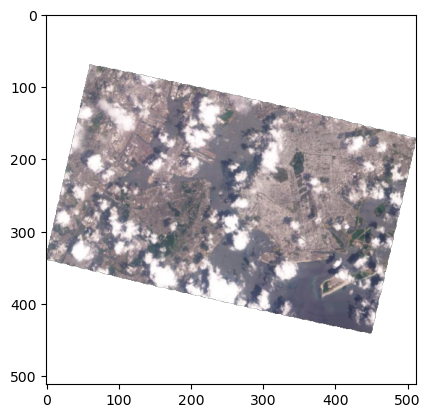

In [87]:
item_id = item_ids[2]

url = f"https://services.sentinel-hub.com/api/v1/dataimport/collections/PLANET_SCOPE/products/{item_id}/thumbnail"
response = oauth.get(url)

image_bytes = io.BytesIO(response.content)
img = mpimg.imread(image_bytes)
plt.imshow(img)
plt.show()

### Order products

The next step after searching data is ordering it. We will use the ids stored in the `item_ids` variable to build our order. In this step, you need to provide your Planet API Key. The request is made of three elements:
- **name** -> order name
- **collectionId** -> collection id 
- **input** -> order details


<div class="alert alert-block alert-success">
<strong>NOTE</strong>: When requesting data, a Colleciton ID is asked. Think of collections as a bucket where data will be delivered. You can login in your <a href="https://apps.sentinel-hub.com/dashboard/">SentinelHub Dashboard</a> and see your collection ids. It is good practice to have one collection id for each data type and provider. For example:
  
    
* My PlanetScope 8-band data -> collection id 1
* My SkySat multispectral data -> collection id 2 
 
<strong>Additionally, note that different item types and bundles aren't compatible, so you cannot mix them in the same BYOC collection</strong>. As a consequence, in one collection id, one tipe of data but all ordered via the same bundle
</div>

Before ordering, let's define some parameters we will need.

In [88]:
# Get Planet API Key

PLANET_API_KEY = getpass.getpass("Enter your Planet API Key")

# TPDI Order API url
url = "https://services.sentinel-hub.com/api/v1/dataimport/orders"

# Collection ids taken from SH Dashboard
collection_id = "ID"

Enter your Planet API Key ········


In [90]:
# Request
request = {
    "name": "test",
    # collectionId is optional. Removing it will create a new collection
    #"collectionId": collection_id,
    "input": {
        "provider": "PLANET",
        "planetApiKey": PLANET_API_KEY,
        "bounds": {"geometry": geom},
        "data": [
            {
                "itemType": "PSScene",
                "productBundle": bundle,
                "harmonizeTo": "NONE",
                "itemIds": item_ids,
            }
        ],
    },
}

# Send request
response = oauth.post(url, json=request)

# Check status
response.raise_for_status()

# Check response
results = response.json()
results

{'id': '20d25ccd-c2c0-435a-bd3a-58f554b9af1e',
 'userId': 'df146356-67a7-4e6b-9746-ed20419b88c8',
 'accountId': 'e53aa9d1-cd09-48d2-966c-37c1e921acce',
 'created': '2024-04-24T12:28:56.839847Z',
 'name': 'test',
 'provider': 'PLANET',
 'input': {'bounds': {'geometry': {'type': 'Polygon',
    'coordinates': [[[-74.067436, 40.658764],
      [-73.930044, 40.658764],
      [-73.930044, 40.763121],
      [-74.067436, 40.763121],
      [-74.067436, 40.658764]]]},
   'properties': {}},
  'data': [{'type': 'catalog',
    'itemType': 'PSScene',
    'productBundle': 'analytic_sr_udm2',
    'itemIds': ['20230611_145337_76_24a9',
     '20230610_152923_58_2470',
     '20230610_152925_72_2470',
     '20230608_153254_81_2254',
     '20230608_153252_66_2254',
     '20230608_153250_51_2254',
     '20230608_152348_86_2473',
     '20230608_152351_04_2473',
     '20230608_145246_56_24ab',
     '20230608_145248_86_24ab',
     '20230608_145251_16_24ab',
     '20230607_145342_27_24be',
     '20230607_145339_

You can check the cost of this request in the `sqkm` key. 

In [91]:
print("Cost in sqkm:", results["sqkm"])

Cost in sqkm: 1492.2947958787713


### Order a subset of products

Perhaps, you only wish to order a subset of the product IDs that were returned to you. To do this you can create a subset of the IDs like in the below cell. In this cell we subset the item IDs for only the date 10/06/2023

In [92]:
item_id = item_ids[1:3]
item_id

['20230610_152923_58_2470', '20230610_152925_72_2470']

In [93]:
# Request
request = {
    "name": "test",
    # collectionId is optional. Removing it will create a new collection
    #"collectionId": collection_id,
    "input": {
        "provider": "PLANET",
        "planetApiKey": PLANET_API_KEY,
        "bounds": {"geometry": geom},
        "data": [
            {
                "itemType": "PSScene",
                "productBundle": bundle,
                "harmonizeTo": "NONE",
                "itemIds": item_id,
            }
        ],
    },
}

# Send request
response = oauth.post(url, json=request)

# Check status
response.raise_for_status()

# Check response
results = response.json()
results

{'id': '4b29ae6f-ac2d-4327-a287-b1ab25ec2ed5',
 'userId': 'df146356-67a7-4e6b-9746-ed20419b88c8',
 'accountId': 'e53aa9d1-cd09-48d2-966c-37c1e921acce',
 'created': '2024-04-24T12:30:32.686632Z',
 'name': 'test',
 'provider': 'PLANET',
 'input': {'bounds': {'geometry': {'type': 'Polygon',
    'coordinates': [[[-74.067436, 40.658764],
      [-73.930044, 40.658764],
      [-73.930044, 40.763121],
      [-74.067436, 40.763121],
      [-74.067436, 40.658764]]]},
   'properties': {}},
  'data': [{'type': 'catalog',
    'itemType': 'PSScene',
    'productBundle': 'analytic_sr_udm2',
    'itemIds': ['20230610_152923_58_2470', '20230610_152925_72_2470'],
    'harmonizeTo': 'NONE'}],
  'provider': 'PLANET'},
 'sqkm': 188.87644871631625,
 'status': 'CREATED'}

You can check the cost of this request in the `sqkm` key. As you can see selecting a subset of item IDs reduces the cost of your order in square kilometers.

In [94]:
print("Cost in sqkm:", results["sqkm"])

Cost in sqkm: 188.87644871631625


### Confirm order

Once the order is created, a confirmation step is required to initiate the process. In this example we are ordering the products listed in `results` and not the `order` but this can be easily modified

<div class="alert alert-block alert-success">
<strong>NOTE</strong>: From this point, quota will be deducted
</div>

In [ ]:
# Confirm order API url
url = f"https://services.sentinel-hub.com/api/v1/dataimport/orders/{results['id']}/confirm"
print("Confirmation URL:", url)

# Send request - QUOTA DEDUCTED
response = oauth.post(url)

# Check status
response.raise_for_status()
print(response.status_code)